In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

from typing import Tuple, TypedDict, List
from scipy.stats import truncnorm, binom, scoreatpercentile
from scipy.stats import beta as Beta

np.random.seed(8675309)

In [2]:
def generate_instances(theta: float, n_i: int) -> Tuple[Tuple[int, int]]:
    """
    Generate n_i "instances" based on theta.
    An "instance" here, as defined in the paper, is represented as a tuple 
    of two integers (r, y) where r is the number of runs and y the number of successes
    We sample successes from a binomial distribution using R99 and theta
    """
    r99 = int(np.ceil(-2. / np.log10(1-theta)))
    ys = binom(r99, theta).rvs(size=n_i)
    return tuple((r99, y) for y in ys)

In [3]:
def perform_bayesian_algorithm(thetas: List[float], N: int, B: int):
    """
    Run the Bayesian algorithm across a set of known thetas, number of Monte Carlo instances N,
    and bootstrap number B.
    Returns the empirical distributions of R99-50 and R99-80 percentiles for each theta.
    """
    instances_array = {th: generate_instances(th, N) for th in thetas}
    # We track the distribution of q-50 and q-80 percentiles across our bootstrap iterations
    r99_results = {th: {50: [], 80: []} for th in thetas}

    for th in thetas:
        instances = instances_array[th]
        for b in range(B):
            # We will be recursively sampling and updating our Beta prior
            r99_b = []
            for inst in random.choices(instances, k=N):
                # Update alpha and beta based on observed data
                alpha, beta = 0.5, 0.5
                alpha = alpha + inst[1]
                beta = beta + inst[0] - inst[1]
                # Grab a sample from our posterior and append R99_b
                th_sample = Beta(alpha, beta).rvs()
                r99_b.append(-2. / np.log10(1 - th_sample))
            # Grab the 50th and 80th percentiles of R99 for this bootstrap iter
            q50 = scoreatpercentile(r99_b, 50)
            q80 = scoreatpercentile(r99_b, 80)
            r99_results[th][50].append(q50)
            r99_results[th][80].append(q80)
            
    return r99_results

### Investigation 1
In our first investigation, we use 100 instances across different values of theta.  
**Note**: Throughout this work, we let $\tau = 1$, and thus $TTS = R_{99}$

In [4]:
thetas = np.linspace(0.1, 0.9, 5)
N = 100
B = 100

# We also convert our known theta values to our known r99 values for plotting
r99_known = [-2 / np.log10(1-th) for th in thetas]

# Perform the Bayesian algorithm
r99_results = perform_bayesian_algorithm(thetas, N, B)

# Calculate statistics from our empirical R99 distributions
# We break the stats up into means and percentiles for easier plotting
r99_mean = {50: [], 80: []}
r99_5th = {50: [], 80: []}
r99_95th = {50: [], 80: []}

for th in thetas:
    dist50, dist80 = r99_results[th][50], r99_results[th][80]
    r99_mean[50].append(np.mean(dist50))
    r99_5th[50].append(scoreatpercentile(dist50, 5))
    r99_95th[50].append(scoreatpercentile(dist50, 95))
    r99_mean[80].append(np.mean(dist80))
    r99_5th[80].append(scoreatpercentile(dist80, 5))
    r99_95th[80].append(scoreatpercentile(dist80, 95))
    


We plot the estimated values of $R99$ ($TTS$) across
our known values of $\theta$. We mark the known $R99$ values with an X.  
Error bars are the empirical 5th and 95th percentiles of our $R99_{50}$ distribution

Text(0, 0.5, 'TTS')

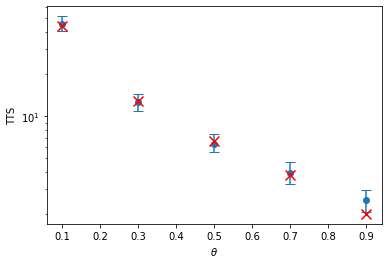

In [5]:
yerr_low = [m - low for m, low in zip(r99_mean[50], r99_5th[50])]
yerr_high = [high - m for m, high in zip(r99_mean[50], r99_95th[50])]
plt.errorbar(thetas, r99_mean[50], yerr=[yerr_low, yerr_high], fmt='o', capsize=5, zorder=0)
plt.scatter(thetas, r99_known, c='r', s=100, marker='x', zorder=1)
plt.xlabel(r'$\theta$')
plt.yscale('log')
plt.ylabel('TTS')

The result here suggests that our mean estimates of R99 are on point.  
The percentile ranges decrease inversely to $\theta$, though logarithmically it's fairly constant.

### Investigation 2
In this investigation, we take a single value $\theta = 0.3$ and investigate how
our estimate scales with number of instances $N$.

In [6]:
thetas = [0.3]
Ns = [10, 100, 1000]
B = 100

r99_results = {n: None for n in Ns}
for n in Ns:
    # Let's just grab the 50th percentiles
    bayes = perform_bayesian_algorithm(thetas, n, B)
    r99_results[n] = bayes[0.3][50]


In [7]:
# Calculate statistics from our empirical R99 distributions
# We break the stats up into means and percentiles for easier plotting
r99_mean = {n: [] for n in Ns}
r99_5th = {n: [] for n in Ns}
r99_95th = {n: [] for n in Ns}

for n in Ns:
    dist50 = r99_results[n]
    r99_mean[n].append(np.mean(dist50))
    r99_5th[n].append(scoreatpercentile(dist50, 5))
    r99_95th[n].append(scoreatpercentile(dist50, 95))

We plot the mean, and percentiles of our $R99$ ($TTS$) estimates across different instance sizes $N$.  
We show known $R99$ for $\theta=0.3$ with a horizontal dashed line.

Text(0, 0.5, 'TTS')

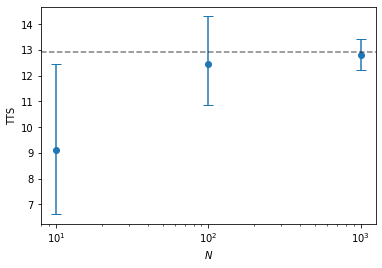

In [8]:
r99_known = -2 / np.log10(1-0.3) # For a hline

y = [r99_mean[n][0] for n in Ns]
y_5 = [r99_5th[n][0] for n in Ns]
y_95 = [r99_95th[n][0] for n in Ns]

yerr_low = [m - low for m, low in zip(y, y_5)]
yerr_high = [high - m for m, high in zip(y, y_95)]

plt.errorbar(Ns, y, yerr=[yerr_low, yerr_high], fmt='o', capsize=5, zorder=0)
plt.xscale('log')
plt.axhline(y=r99_known, color='k', alpha=0.5, linestyle='--')
plt.xlabel(r'$N$')
plt.ylabel('TTS')

### Investigation 3
Let's try varying number of bootstraps

In [9]:
thetas = [0.3]
N = 100
Bs = [10, 100, 1000]

r99_results = {b: None for b in Bs}
for b in Bs:
    # Let's just grab the 50th percentiles
    bayes = perform_bayesian_algorithm(thetas, N, b)
    r99_results[b] = bayes[0.3][50]


In [10]:
# Calculate statistics from our empirical R99 distributions
# We break the stats up into means and percentiles for easier plotting
r99_mean = {b: [] for b in Bs}
r99_5th = {b: [] for b in Bs}
r99_95th = {b: [] for b in Bs}

for b in Bs:
    dist50 = r99_results[b]
    r99_mean[b].append(np.mean(dist50))
    r99_5th[b].append(scoreatpercentile(dist50, 5))
    r99_95th[b].append(scoreatpercentile(dist50, 95))

We plot our TTS estimates across $B$, with a horizontal line of the known $R_{99}$ for $\theta=0.3$

Text(0, 0.5, 'TTS')

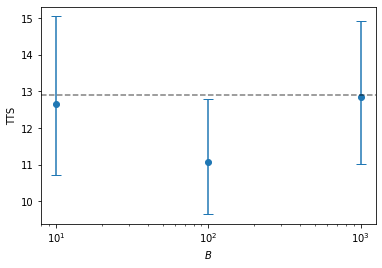

In [11]:
r99_known = -2 / np.log10(1-0.3) # For a hline

y = [r99_mean[b][0] for b in Bs]
y_5 = [r99_5th[b][0] for b in Bs]
y_95 = [r99_95th[b][0] for b in Bs]

yerr_low = [m - low for m, low in zip(y, y_5)]
yerr_high = [high - m for m, high in zip(y, y_95)]

plt.errorbar(Bs, y, yerr=[yerr_low, yerr_high], fmt='o', capsize=5, zorder=0)
plt.xscale('log')
plt.axhline(y=r99_known, color='k', alpha=0.5, linestyle='--')
plt.xlabel(r'$B$')
plt.ylabel('TTS')